## Interactive model tester
This allows interactive use of a saved Estimator model against systems configured for the **formal-test-set**.

In [1]:
from pathlib import Path
import json
import re
from textwrap import fill

import numpy as np
import astropy.units as u

%matplotlib widget 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Support for interactive widgets
from IPython.display import *
from ipywidgets import *

from ebop_maven.libs import lightcurve,jktebop
from ebop_maven import datasets
from ebop_maven.estimator import Estimator
import plots, model_testing

### Create our Estimator
Loads the trained machine learning model into an Estimator class. The Estimator makes the model easier to use by handling inputs & outputs, naming features & labels and any scaling of label values.

In [2]:
model_files = [Path.cwd() / "ebop_maven/data/estimator/default-model.keras"] \
                + sorted((Path.cwd() / "drop").glob("*.keras"))
default_model = model_files[0]

model_selection = Dropdown(options=[(f.stem, f) for f in model_files], value=default_model, description="Models: ")
display(model_selection)

Dropdown(description='Models: ', options=(('default-model', PosixPath('/home/steveo/projects/main/ebop_maven/e…

In [3]:
estimator = Estimator(model=model_selection.get_interact_value())

Estimator loading model file '/home/steveo/projects/main/ebop_maven/ebop_maven/data/estimator/default-model.keras'...
Loaded model 'CNN-New-Ext0-bP-4096-0.75' last modified at 2024-05-20T19:56:40.146788.
Each input dict to contain:    mags (with mags to have 4096 bins with the phases after 0.75 wrapped)
Each output dict will publish: rA_plus_rB, k, J, ecosw, esinw, bP (and corresponding <key>_sigma uncertainty values)


### Target selection
These targets are taken from the **formal-test-dataset**. These are accompanied with published parameters which we can use to test our results. Targets marked with an asterisk have been excluded from formal testing.

In [4]:
# Our initial target and where to source fitting inputs
default_target = "AI Phe"
do_control_fit = False

targets_config_file = Path.cwd() / "config" / "formal-test-dataset.json"
with open(targets_config_file, mode="r", encoding="utf8") as cf:
    targets_cfg = json.load(cf)

options = [(f"{t} *" if c.get("exclude", False) else f"{t}", t) for t, c in targets_cfg.items()]
target_selection = Dropdown(options=options, value=default_target, description="Targets:")
display(target_selection)

Dropdown(description='Targets:', index=21, options=(('V436 Per', 'V436 Per'), ('V539 Ara', 'V539 Ara'), ('psi …

### Ingest the lightcurves
Searches for the target in the MAST archive and downloads timeseries fits files. Subsequent calls may be serviced from a local cache.

For each lightcurve we perform the following initial ingest actions:
- mask out rows where the quality column matches the quality_bitmask from the target's config
- optionally mask out any distorted regions indicated by quality_mask (from, to) time ranges in the target's config
- optionally bin the lightcurve as indicated by any bin_time item in the target's config
- generate delta_mag and delta_mag_err differential magnitude columns
- de-trend the lightcurve by fitting and subtracting a low-order polyomial
- create a phase-folded copy of the lightcurve, about the primary_epoch and period from the target's config

Once we have the phase-folded lightcurves we can fit an interpolated model to it
with the number of bins matching the input requirement of the Estimator's mag feature.
Alongside this we gather any further simple feature values the Estimator will require.

In [5]:
# Download, load and pre-process the target's lightcurve data
# which will be read, rectified & extended with delta_mag and delta_mag_err cols
target = target_selection.get_interact_value()
target_cfg = targets_cfg[target]
(lc, sector_count) = datasets.prepare_lightcurve_for_target(target, target_cfg)

# These are mandatory, so error if missing
labels = target_cfg["labels"]
period = target_cfg["period"] * u.d
pe = lightcurve.to_lc_time(target_cfg["primary_epoch"], lc)

# Get the phase folded and binned mags feature
print(f"Creating phase normalized, folded lightcurves about", f"{pe.format} {pe} & {period}.")
mags_bins = estimator.mags_feature_bins
wrap_phase = estimator.mags_feature_wrap_phase
fold_lc = lc.fold(period, pe, wrap_phase=u.Quantity(wrap_phase), normalize_phase=True)
phases, mags = lightcurve.get_reduced_folded_lc(flc=fold_lc, num_bins=mags_bins, phase_pivot=wrap_phase)

Searching for lightcurves based on; target=AI Phe, sectors=[2], mission=TESS, author=SPOC and exptime=short
Looking for previously downloaded fits within /home/steveo/projects/main/ebop_maven/cache/ai_phe
Found 1 existing fits matching mission and author criteria
Found the required 1 fits also meeting the sectors & exptime criteria. Will load the requested lightcurves from these.
NaN/negative flux masks match 0 row(s).
Creating a flatten transit mask from 2 transit time range(s) and the orbital period of 24.5924 d.
Flattening the Light-curve
Will detrend (and rectify by subracting trends) over the following range [btjd]: 1354.111847-1381.517616
	Generated polynomial; y = poly(x, c0=5.207894e-04, c1=2.437518e-05) (sigma(fit_ydata)=1.979262e-04 mag)
Creating phase normalized, folded lightcurves about btjd 1362.828326117 & 24.5924 d.


### Plot the target light-curve alongside the phase folded model
Make a plot of the ingested lightcurve with the position of the primary epoch
highlighted and the phase-folded lightcurve overlaid with the interpolated mags
feature which will be used as an input to the Estimator.

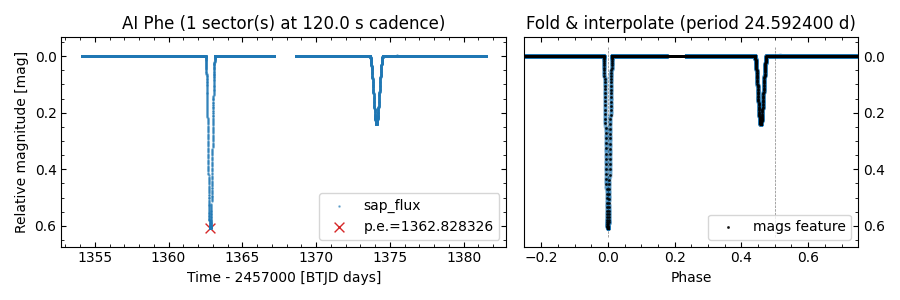

AI Phe: An eccentric orbit with the secondary occuring before phase 0.5. Star B is significantly
larger and evolved with k~1.6. Only sector 2 shows both transits with sectors 29 and 69 having
incomplete transits.


In [6]:
fig = plt.figure(figsize=(9, 3), tight_layout=True)
gs = GridSpec(figure=fig, ncols=2, nrows=1, width_ratios=(4, 3))
target_label = target_cfg.get("label", target)

exptime = lc.meta["FRAMETIM"] * lc.meta["NUM_FRM"] * u.s  
pe_mag = lc["delta_mag"].max().value

ax_lc = fig.add_subplot(gs[0, 0])
lc.scatter(ax=ax_lc, column="delta_mag", s=3, alpha=.5, label=lc.meta['FLUX_ORIGIN'])
ax_lc.scatter([pe.value], [pe_mag], marker="x", s=50., lw=1., c="tab:red",
                label=f"p.e.={pe.value:.6f}", zorder=-10)
plots.format_axes(ax_lc, title=f"{target_label} ({sector_count} sector(s) at {exptime} cadence)",
                  ylabel="Relative magnitude [mag]", inverty=True, legend_loc="best")

ax_fld = fig.add_subplot(gs[0, 1], sharey=ax_lc)
fold_lc.scatter(ax=ax_fld, column="delta_mag", s=20, alpha=.25, label=None)
ax_fld.scatter(phases, mags, c="k", alpha=.75, marker=".", s=5, lw=1, label="mags feature")
(ymin, ymax) = ax_fld.get_ylim()
ax_fld.vlines([0.0, 0.5], ymin, ymax, linestyles="--", color="k", lw=.5, alpha=.5)
plots.format_axes(ax_fld, title=f"Fold & interpolate (period {period:.6f})", ylabel="",
                    xlim=(min(phases), max(phases)), yticklabel_right=True, legend_loc="best")
plt.show()
print(fill(f"{target}: " + target_cfg.get("desc", ""), 100))

### Estimate the JKTEBOP fitting parameters
This is where the magic happens!

Estimator is used to predict the values of the $r_A+r_B$, $k$, $J$,
$e\cos{\omega}$, $e\sin{\omega}$ and $i$ parameters (or $b_P$ instead of $i$
if the model has been trained for it) for use as input values of subsequent
fitting with JKTEBOP.

If iterations >1 then the MC Dropout algorithm will be used which repeats the
requested predictions the given number of times with Dropout enabled. Dropout
randomly drops a proportion of the neurons in the full neural network, so in
this configuration each iteration will give a predition from a different subset
of the full network. The final output predictions will be the mean and 1-sigma
values calculated from the set of predictions from every iteration.

The table shows the predictions (nominals) against the (published) label values
along with the residual, MAE and MSE loss metrics.

In [7]:
# An iterations value over 1 triggers the MC Dropout algorithm giving us nominal and 1-sigma values.
# The model predicts scaled values (e.g. inc*0.01) which the Estimator "unscales" for us.
ecosw, esinw = labels["ecosw"], labels["esinw"]
instance_features = [{ 
    "mags": mags,

    # These are ignored when not supported by the Estimator model
    "phiS": lightcurve.expected_secondary_phase(ecosw=ecosw, esinw=esinw),
    "dS_over_dP": lightcurve.expected_ratio_of_eclipse_duration(esinw)
}]
predictions = estimator.predict(instance_features, iterations=1000)[0]

# Handle the estimator predicting bP rather than inc directly; JKTEBOP uses inc
if "inc" not in predictions and "bP" in predictions:
    print(f"The {estimator.name} doesn't predict inc so it is calculated from other predictions")
    model_testing.append_calculated_inc_prediction(predictions)

# Produce some statistics on the quality of the predictions.
print(f"The Estimator's predictions for {target}")
model_testing.predictions_vs_labels_to_table([labels], [predictions], [target])

The CNN-New-Ext0-bP-4096-0.75 doesn't predict inc so it is calculated from other predictions
The Estimator's predictions for AI Phe
---------------------------------------------------------------------------------------------------------------
AI Phe     | rA_plus_rB          k          J      ecosw      esinw         bP        inc        MAE        MSE
---------------------------------------------------------------------------------------------------------------
Label      |   0.098950   1.625500   0.500000  -0.065161   0.176500   0.623000  88.359000
Prediction |   0.127452   1.513783   0.508247  -0.065066   0.140355   0.473930  88.391312
O-C        |  -0.028502   0.111717  -0.008247  -0.000095   0.036145   0.149070  -0.032312   0.052298   0.005419
MAE        |   0.028502   0.111717   0.008247   0.000095   0.036145   0.149070   0.032312   0.052298
MSE        |   0.000812   0.012481   0.000068   0.000000   0.001306   0.022222   0.001044              0.005419



### Perform JKTEBOP fitting on the target's lightcurves
The parameters estimated above and the ingested lightcurves are now used to generate
an equivalent pair of in & dat files for the target. JKTEBOP is invoked against these
to fit the lightcurve with the EBOP algorithm.

In [8]:
# JKTEBOP won't overwrite files so make sure we clear down anything which could cause trouble
file_stem = f"int-tester-{re.sub(r'[^\w\d-]', '-', target.lower())}"
for file in jktebop.get_jktebop_dir().glob(f"{file_stem}.*"):
    file.unlink()

in_filename = jktebop.get_jktebop_dir() / f"{file_stem}.in"
dat_filename = jktebop.get_jktebop_dir() / f"{file_stem}.dat"
par_filename = jktebop.get_jktebop_dir() / f"{file_stem}.par"

# We have the option of fitting the labels.
# This allows us to test whether a good fit can be achieved with appropriate inputs.
if do_control_fit:
    print("\033[93mWarning\033[0m: Control fit: labels are used for the fitting input parameters\n")
    input_params = labels.copy()
else:
    input_params = predictions.copy()

# published fitting params that may be needed for good fit
fit_overrides = target_cfg.get("fit_overrides", {})
lrats = fit_overrides.get("lrat", [])

params = {
    **model_testing.base_jktebop_task3_params(
                    period.to(u.d).value, pe.value, dat_filename.name, file_stem, target_cfg),
    **input_params,             # from either estimator or labels (see above)
    **fit_overrides,
}

# Add scale-factor poly fitting, chi^2 adjustment (to 1.0) or light-ratio instructions
segments = lightcurve.find_lightcurve_segments(lc, 0.5, return_times=True)
append_lines = jktebop.build_poly_instructions(segments, "sf", 1)
append_lines += ["", "chif", ""] + [ f"lrat {l}" for l in lrats ]

jktebop.write_in_file(in_filename, task=3, append_lines=append_lines, **params)
jktebop.write_light_curve_to_dat_file(
    lc, dat_filename, column_formats=[lambda t: f"{t.value:.6f}", "%.6f", "%.6f"])

# Don't consume the output files so they're available for subsequent plotting
print(f"Fitting {target} using JKTEBOP task 3...")
par_contents = list(jktebop.run_jktebop_task(in_filename, par_filename, stdout_to=sys.stdout))

Fitting AI Phe using JKTEBOP task 3...
  
JKTEBOP  v44  John Southworth (Keele University, UK, taylorsouthworth~gmail.com)
Task 3  finds the best fit of the model to observations  (formal errorbars only)
>> Read parameters for polynomial  1, to be applied to parameter "sf" over a given time interval
>> Read parameters for polynomial  2, to be applied to parameter "sf" over a given time interval
>> Opened new parameter  file:  int-tester-ai-phe.par                             
>> Opened new LC output  file:  int-tester-ai-phe.out                             
>> Opened new model fit  file:  int-tester-ai-phe.fit                             
>> Read  18298 datapoints (with errors) from file int-tester-ai-phe.dat                             
>> Read  2 polynomial datasets from the input file
>> Best fit has been found after 38 iterations.
>> Done iteration 1 to adjust errorbars. Chisqred values:   1.081 
>> Done iteration 2 to adjust errorbars. Chisqred values:   1.000 
>> Best fit has bee

### Review the JKTEBOP fitting results
For each fitted target, JKTEBOP produces parameter (par), model (fit) and
fitted lightcurve (out) files. We plot the phase folded lightcurve data
overlaid with the corresponding fitted model the out file.

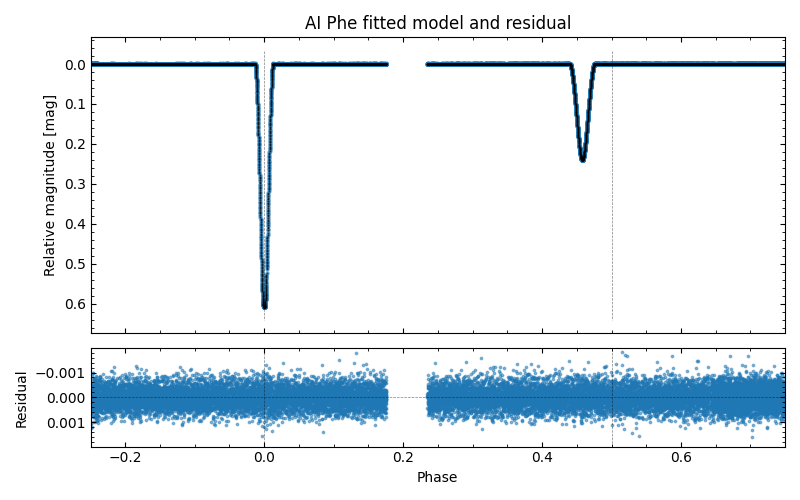

In [9]:
# Read the fit data from the out file, and roll the phases to match that used in estimations
with open(jktebop.get_jktebop_dir() /f"{file_stem}.out", mode="r", encoding="utf8") as ff:
    fit_data =  np.loadtxt(ff, usecols=[3, 4, 5], comments="#", dtype=np.double, unpack=True)
    fit_data[0][fit_data[0] > np.max(fold_lc.time).value] -= 1.

# A grid of two stacked Axes. Upper for the folded lc & model and lower for the residuals
fig = plt.figure(figsize=(8, 5), tight_layout=True)
gs = GridSpec(figure=fig, ncols=1, nrows=2, height_ratios=(3, 1))
ax_fld = fig.add_subplot(gs[0, 0])
fold_lc.scatter(ax=ax_fld, column="delta_mag", s=20, alpha=.5, label=None)
ax_fld.scatter(fit_data[0], fit_data[1], c="k", alpha=.5, marker=".", s=3, lw=.5, label=None)
(ymin, ymax) = ax_fld.get_ylim()
ax_fld.vlines([0.0, 0.5], ymin, ymax, linestyles="--", color="k", lw=.5, alpha=.5)
ylabel = "Relative magnitude [mag]"
plots.format_axes(ax_fld, xlabel="",ylabel=ylabel, xlim=(min(phases),max(phases)), inverty=True,
                    title=f"{target_cfg.get('label', target)} fitted model and residual")
plt.setp(ax_fld.get_xticklabels(), visible=False) # Hides xtick labels on this part shared axes

ax_res = fig.add_subplot(gs[1, 0], sharex=ax_fld)
ax_res.scatter(x=fit_data[0], y=fit_data[2], s=3, alpha=.5)
abs_max_ylim = max(np.abs(ax_res.get_ylim()))
plots.format_axes(ax_res, title="", xlabel="Phase", ylabel="Residual",
                    xlim=(min(phases), max(phases)), ylim=(abs_max_ylim, -abs_max_ylim))
(ymin, ymax) = ax_res.get_ylim()
ax_res.vlines([0.0, 0.5], ymin, ymax, linestyles="--", color="k", lw=.5, alpha=.5)
ax_res.hlines([0.0], min(phases), max(phases), linestyles="--", color="k", lw=.5, alpha=.5)
plt.show()

In [10]:
fit_prms = ["rA_plus_rB", "k", "J", "ecosw", "esinw", "inc", "L3", "bP", "ecc", "omega", "rA", "rB"]
jktebop_preds = []
fitted_params = jktebop.read_fitted_params_from_par_lines(par_contents, fit_prms)

print(f"{target} JKTEBOP fitted parameters")
for param, (val, err) in fitted_params.items():
    print(f"{param:>10s}: {val:10.6f}", f"+/- {err:.6f}" if err else "")

AI Phe JKTEBOP fitted parameters
rA_plus_rB:   0.098847 +/- 0.000038
         k:   1.628862 +/- 0.000527
         J:   0.525127 +/- 0.001575
     ecosw:  -0.065168 +/- 0.000005
     esinw:   0.175653 +/- 0.000371
       inc:  88.358618 +/- 0.001782
        L3:   0.005300 
        bP:   0.625221 
       ecc:   0.187352 
     omega: 110.355126 
        rA:   0.037601 
        rB:   0.061247 


In [11]:
print(f"The JKTEBOP model's fitted parameters vs the label values for {target}")
fitted_labels = ["inc" if n == "bP" else n for n in estimator.label_names]
model_testing.predictions_vs_labels_to_table([labels], [fitted_params], [target],
                                             fitted_labels, prediction_head="Fitted")

The JKTEBOP model's fitted parameters vs the label values for AI Phe
----------------------------------------------------------------------------------------------------
AI Phe     | rA_plus_rB          k          J      ecosw      esinw        inc        MAE        MSE
----------------------------------------------------------------------------------------------------
Label      |   0.098950   1.625500   0.500000  -0.065161   0.176500  88.359000
Fitted     |   0.098847   1.628862   0.525127  -0.065168   0.175653  88.358618
O-C        |   0.000103  -0.003362  -0.025127   0.000007   0.000847   0.000382   0.004971   0.000107
MAE        |   0.000103   0.003362   0.025127   0.000007   0.000847   0.000382   0.004971
MSE        |   0.000000   0.000011   0.000631   0.000000   0.000001   0.000000              0.000107

